In [5]:
from math import*
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

We want to solve Friedmann's equation in the case of a matter-dominated universe, with no curvature:
$$
\frac{\ddot{a}}{a} = -4\pi G\rho /3
$$
with continuity's equation:
$$  
\frac{d\rho}{dt} + 3H\rho = 0
$$

The solution for a closed universe is:
$$
a(\eta) = \frac{1}{2}a_0(1 + \cos(\eta))
$$
$$
\tau = \frac{1}{2}a_0(\eta + \sin(\eta))
$$
and for a flat universe:
$$
a(t) \propto t^{2/3}
$$

In [6]:
def trouver_ind(L,n):
    for i in range(len(L)):
        if n==L[i]:
            return i
    return -1

In [7]:
def find_closer(L,n):
    eps = 10e-3
    for i in range(len(L)):
        if (np.abs(L[i] - n) < eps):
            return i

In [8]:
G = 6.67e-20
c = 3e8
Lambda = 1.088e-52*c**2
def dyn_FRW_Lambda(t,y):
    dot_a = y[1]
    a = y[0]
    rho = y[2]
    f = [dot_a,-4*np.pi*G*rho/3*a + Lambda/3*a, -3*dot_a/a*rho]
    return f

In [9]:
G = 1
c = 1
def dyn_FRW(t,y):
    dot_a = y[1]
    a = y[0]
    rho = y[2]
    H = dot_a/a
    f = [dot_a,-4*np.pi*G*rho/3*a, -3*H*rho]
    return f

In [ ]:
def dyn_FRW_EdS(t,y):
    """
    Evlution equation for an EdS Universe.
    """
    dot_a = y[1]
    a = y[0]
    rho = y[2]
    a_EdS = y[3]
    a_dot_EdS = y[4]
    rho_EdS = y[5]
    H = dot_a/a
    H_EdS = a_dot_EdS/a_EdS
    f = [dot_a,-4*np.pi*G*rho/3*a, -3*H*rho, a_dot_EdS,-4*np.pi*G*rho_EdS/3*a_EdS, -3*H_EdS*rho_EdS]
    return f

In [ ]:
G = 1
c = 1
def dyn_FRW_Lambda(t,y):
    """Evolution equation for a FRLW Universe with cosmological constant."""
    dot_a = y[1]
    a = y[0]
    rho = y[2]
    H = dot_a/a
  #  H_L = a_dot_L/a_L
    f = [dot_a,-4*np.pi*G*rho/3*a, -3*H*rho]
    return f

In [ ]:
def dyn_FRW_perturbe_homogène(t, y, *args):
    R_i = y[0]
    dot_R_i = y[1]
    rho_tilde = y[2]
    x = y[3]
    x_dot = y[4]

    rho_2 = y[5]
    a = y[6]
    dot_a = y[7]

    H = dot_a/a
    H_I = dot_R_i/R_i
    rho_c = 3*H_I**2/(8*np.pi*G)
    Lambda = args[0]

    f = [dot_R_i,-4*np.pi*G*rho_tilde/3*R_i + Lambda, -3*dot_R_i/R_i*rho_tilde, x_dot, 4*np.pi*G*rho_tilde*x - 2*H_I*x_dot, -3*H*rho_2, dot_a, -4*np.pi*G*rho_2/3*a]
    return f

In [98]:
class Solver_cosmo():
    def __init__(self, Time, reverse_Time, rtol = 1e-9):
        self.Time = Time
        self.reverse_Time = reverse_Time

        self.rtol = rtol

    def solve_friedmann(self, a_in, a_dot_in, eps_in):

        H = a_dot_in/a_in #Hubble constant

        if eps_in > 0:
            R_ta = (1 + eps_in)/eps_in*a_in
            t_ta = np.pi*(1 + eps_in)/(2*H*eps_in**(3/2))
        else:
            t_ta = 1


        rho_c_in = 3*H**2/(8*np.pi*G) #Critical overdensity

        rho_in = rho_c_in*(1 + eps_in)

        sol = solve_ivp(dyn_FRW_Lambda, [0, self.Time[-1]], [a_in,a_dot_in, rho_in], t_eval = self.Time, rtol = self.rtol) #Forward resolution

        sol_rev = solve_ivp(dyn_FRW_Lambda, [0,self.reverse_Time[-1]], [a_in,a_dot_in, rho_in], t_eval = self.reverse_Time) #Backward resolution

        m = np.min(sol_rev.t)
        sol_t = np.flip(sol_rev.t)
        Time = [sol_t[i]/t_ta - m/t_ta for i in range(len(sol_rev.t))] + [sol.t[i]/t_ta - m/t_ta for i in range(1,len(sol.t))]
        sol_rev_L = np.flip(sol_rev.y[0])
        sol_L = [sol_rev_L[i] for i in range(len(sol_rev.y[0]))] + [sol.y[0][i] for i in range(1,len(sol.y[0]))]

        if eps_in > 0:
            plt.figure(figsize=(7,5))
            plt.plot(Time, sol_L, label = "Positively Curved Universe")
            plt.axvline(1, 0, 11*R_ta/10 , linestyle = 'dashed', color = 'green') #Vertical line
            plt.axhline(R_ta, 0, 11*2/10, linestyle = 'dashed', color = 'orange') #Horizontal line
            plt.text(0.9, R_ta*1.01, 'Turn-around', horizontalalignment='center', verticalalignment='center', fontsize = 'x-small')
            plt.xlabel('t/t_a')
            plt.ylabel('a')
            plt.legend()
        elif eps_in == 0:
            plt.plot(Time, sol_L, label = 'Flat Universe')
            plt.legend()

    def growing_mode(self, a_in, a_dot_in, R_in, R_dot_in, x_in, x_dot_in, Lambda, label, t_max, N_point):

        #Background
        H = a_dot_in/a_in
        rho_2_in = (a_dot_in/a_in)**2*3/(8*np.pi*G)

        #Gas cluster
        H_I = R_dot_in/R_in
        rho_in = rho_c_in*(1 + eps_in)

        sol_x = solve_ivp(fun=lambda t,y : dyn_FRW_perturbe_homogène(t,y, (Lambda)), t_span=[0,t_max], y0=[R_in, R_dot_in, rho_in, x_in, x_dot_in, rho_2_in, a_in, a_dot_in], t_eval = np.linspace(0,t_max, N_point), rtol = 1e-10) #On perturbe rho avec epsilon

        D_g = sol_x.y[3]
        A = sol_x.y[6]

        plt.rcParams.update({'font.size': 10})
        plt.loglog(sol_x.y[6], sol_x.y[3], label = label) #mode croisant v.s facteur d'échelle
        plt.ylabel("$D_+$")
        plt.xlabel('a')
        plt.legend()

## With curvature

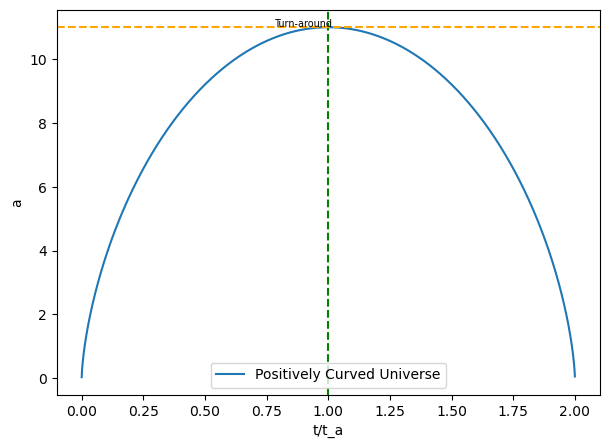

In [68]:
n = 10000
m = 100*n

G = 1
a_in = 1
a_dot_in = 1 #Voir approximation de Zel'dovich
eps_in = 0.1
H = a_dot_in/a_in

Time = np.linspace(0,n,m)
reverse_Time = np.linspace(0,-n,m)

cosmo = Solver_cosmo(Time, reverse_Time)

cosmo.solve_friedmann(a_in, a_dot_in, eps_in)

Flat Universe

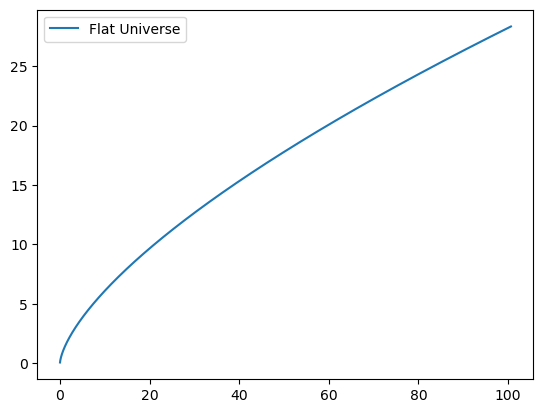

In [69]:
n = 100
m = 100*n

t_ta = 1 #Pour l'instant
scale_a = 1
scale_a_dot = 0.1 #Scale factor dans le cas d'un univers EdS
eps_in = 0

Time = np.linspace(0,n,m)
reverse_Time = np.linspace(0,-n,m)

cosmo = Solver_cosmo(Time, reverse_Time)

cosmo.solve_friedmann(a_in, a_dot_in, eps_in)

Growing mode in an EdS. In an EDS, there is no curvature or Dark Energy. According to theory, one should have $\delta \propto a$.

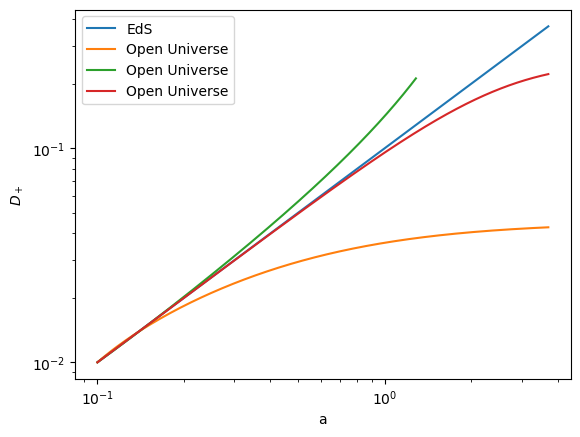

In [132]:
n = 100
m = 100*n

cosmo = Solver_cosmo(Time, reverse_Time)

a_in = .1
a_dot_in = 5 #Scale factor dans le cas d'un univers EdS
eps_in = 0
H = a_dot_in/a_in

R_in = 1
R_dot_in = R_in*H*(1 - eps_in/3)

H_I = R_dot_in/R_in
rho_c_in = (R_dot_in/R_in)**2*3/(8*np.pi*G)

x_in = .01
x_dot_in = x_in*H*(1 - eps_in/3)

Time = np.linspace(0,n,m)
reverse_Time = np.linspace(0,-n,m)

cosmo.growing_mode(a_in, a_dot_in, R_in, R_dot_in, x_in, x_dot_in, 0, 'EdS', 3, 5000)

######################################################################################################################
a_in = 0.1
a_dot_in = 5
H = a_dot_in/a_in
eps_in = -0.5
R_in = 1
R_dot_in = R_in*H*(1 - eps_in/3)


H_I = R_dot_in/R_in
rho_c_in = (R_dot_in/R_in)**2*3/(8*np.pi*G)
#t_ta = np.pi/2/(H_I*eps_in**3)

rho_in = rho_c_in*(1 + eps_in)

x_in = .01
x_dot_in = x_in*H*(1 - eps_in/3)

cosmo.growing_mode(a_in, a_dot_in, R_in, R_dot_in, x_in, x_dot_in, 0, 'Open Universe', 3, 5000)

######################################################################################################################
a_in = 0.1
a_dot_in = 1
H = a_dot_in/a_in
eps_in = 0.1
R_in = 0.11
R_dot_in = R_in*H*(1 - eps_in/3)


H_I = R_dot_in/R_in
rho_c_in = (R_dot_in/R_in)**2*3/(8*np.pi*G)

rho_in = rho_c_in*(1 + eps_in)

x_in = .01
x_dot_in = x_in*H*(1 - eps_in/3)

cosmo.growing_mode(a_in, a_dot_in, R_in, R_dot_in, x_in, x_dot_in, 0, 'Open Universe', 3, 5000)

###############################################################################################
a_in = 0.1
a_dot_in = 5
H = a_dot_in/a_in
eps_in = 0
R_in = 1
R_dot_in = R_in*H*(1 - eps_in/3)

H_I = R_dot_in/R_in
rho_c_in = (R_dot_in/R_in)**2*3/(8*np.pi*G)

rho_in = rho_c_in*(1 + eps_in)

Lambda = 6

x_in = .01
x_dot_in = x_in*H*(1 - eps_in/3)

cosmo.growing_mode(a_in, a_dot_in, R_in, R_dot_in, x_in, x_dot_in, 6, 'Open Universe', 3, 5000)


We now want to caracterise the evolution of
$$
x = \frac{\Delta r}{R_I^{(0)}},
$$
where $\Delta r = r - r_{\text{cm}}$. $r_{\text{cm}} = \frac{1}{M}\int_{\Omega} \rho r d^3 r$.
By simply applying Newton's gravitational law, one can show that this unknown satisfies:
$$
\nabla_q \cdot \ddot{x} + 2H_I\nabla_q \cdot \dot{x} = \frac{3H_I^2}{2} \Omega_{m,I} \nabla_q \cdot x
$$

Recall that $\epsilon_R$ is defined as:
$$
\epsilon_R = \frac{5}{M R_I^2}\int_{V_R} d\textbf{r} \quad (\textbf{r} - \textbf{r}_{CM})\cdot\nabla \phi (\textbf{r}) \approx \frac{5}{R^5} \int_0^R dr r^4 \delta_r 
$$

Let
$$
H_I = \frac{\dot{R}_I^{(0)}}{R_I^{(0)}},
$$
and
$$
\Omega_{m,I} = 1 - \Omega_{K,I}.
$$
$R_I^{(0)}$ is by definition solution of :
$$
\frac{\ddot{R_I}^{(0)}}{R_I^{(0)}} = -\frac{G M_I^{(0)}}{R_I^{(0),3}}
$$
where $M_I^{(0)} = \frac{4\pi}{3} \rho R_I^{(0),3} (1 + \epsilon_R)$ is conserved up to order 1 included. In the same spirit, let $\tilde{\rho} = \bar{\rho}(1 + \epsilon_R)$

A universe with a positive potential gravitational energy overdensity can be seen as a positive curvature constant: $K = - 2E \approx \frac{GM_I}{R_I}\epsilon_R \approx \frac{4\pi}{3}\tilde{\rho}G R_I^{(0),2}\epsilon_R > 0$. 

So, let :
$$
\frac{\ddot{R_I}^{(0)}}{R_I^{(0)}} = -\frac{4\pi G \tilde{\rho}}{3},
$$
and
$$
\frac{d\tilde{\rho}}{dt} + 3H_I \tilde{\rho} = -3H_Ip/c^2 = 0.
$$

OThis two equations actually includes the first Friedmann's equation:
$
H^2 = \frac{8\pi G}{3}\rho - \frac{K}{a^2}.
$


Regarding initial consitions, you have to specify : $R_I^{0}(0), \dot{R}_I^{0}(0), \epsilon(0)$. Everything can be buit from this.
Starting from
$$
\Omega_{m,I} = 1 - \Omega_{K,I} = 1 + 2\frac{4\pi\tilde{\rho}G\epsilon_{in} R_I^{(0),2}}{3 H_I^2 R_I^2} = \frac{\tilde{\rho}}{\rho_c},
$$
one finds that
$$
\tilde{\rho}_{in} = \rho_{c,in}(1 + \epsilon_{in}),
$$
and of course $\rho_{c,in} = \frac{3 H_{I,in}^2}{8\pi G}$.

For a spherically symmetric and homogeneous perturbation, the solutions are well-known. The perturbation will evolve and reach its peak at the "turn-around" time, i.e., $t_{t.a} = \displaystyle{\frac{1 + \delta_{R,in}}{H_{in}\delta_{R,in}^{\frac{3}{2}}}}\frac{\pi}{2}$.

We want to plot here the critical overdensity. The critical overdensity is defined as the linear overdensity at the moment the clump of gas is virialised, according to the classical theory of self-collapse by an isotropic homogeneous perturbation. It serves as a reference to figure out if an object is at equilibrium or not.

For an EdS Universe, it can be shown that:
$$
\delta_c = \frac{3}{5}\left(\frac{3}{4}\left(\theta_{\text{vir}} - \sin(\theta_{\text{vir}})\right)\right)^{2/3},
$$
while for $\Omega_0 < 1$:
$$
\delta_c = \left(-1 + \left(\frac{2\pi}{\theta_{\text{vir}} - \sin(\theta_{\text{vir}})}\right)^{2/3}\right)\left(3 + 9\sin(\theta_{\text{vir}})\left(-2\theta_{\text{vir}} + \frac{\sin(\theta_{\text{vir}})}{2(\cos(\theta_{\text{vir}}) - 1)^2}\right)\right),
$$
and $\Omega_0 > 1$:
$$
\delta_c = \left(-1 + \left(\frac{2\pi}{\sinh(\theta_{\text{vir}}) - \theta_{\text{vir}}}\right)^{2/3}\right)\left(-3 + 9\sinh(\theta_{\text{vir}})\left(-2\theta_{\text{vir}} + \frac{\sinh(\theta_{\text{vir}})}{2(\cosh(\theta_{\text{vir}}) - 1)^2}\right)\right).
$$

In [133]:
eps_pos = [(-1 + (2*np.pi)**(2/3)*(1/(i*2*np.pi/50 - np.sin(2*np.pi*i/50))**(2/3)))*(3 + 9*np.sin(2*np.pi*i/50)*(-2*np.pi*i/50 + np.sin(2*np.pi*i/50))/(2*(-1 + np.cos(2*np.pi*i/50))**2)) for i in range(1,13)]
Omega_pos = [2/(1 + np.cos(2*np.pi/50*i)) for i in range(1,13)]

In [134]:
eps_neg = [(1 + (2*np.pi)**(2/3)*(1/(-i*2*np.pi/50 + np.sinh(2*np.pi*i/50))**(2/3)))*(-3 + 9*np.sinh(2*np.pi*i/50)*(-2*np.pi*i/50 + np.sinh(2*np.pi*i/50))/(2*(-1 + np.cosh(2*np.pi*i/50))**2)) for i in range(50,2, -1)]
Omega_neg = [2/(1 + np.cosh(2*np.pi/50*i)) for i in range(50,2,-1)]

Text(0.5, 0, 'Omega_0')

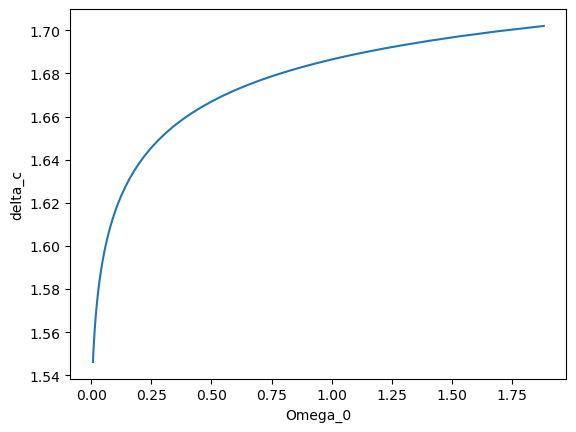

In [135]:
Omega = Omega_neg + Omega_pos
eps = eps_neg + eps_pos
plt.plot(Omega, eps)
plt.ylabel('delta_c')
plt.xlabel('Omega_0')

The resolution of this equation provides the growing mode that we were looking for $\nabla_q \cdot \dot x$, and consequently its temporal behaviour in Zel'dovich's approximation. We can finally show that $y = \displaystyle\frac{R_I^{(1)}}{R_I^{(0)}}$ solves:
\begin{equation}
\ddot{y} + 2H_I\dot{y} = \frac{3}{2}\Omega_{m}(t) H_I^2y - G\frac{M_I^{(1)}}{R_I^{(0),3}} + 2k = 4\pi G \bar{\rho}y - G\frac{M_I^{(1)}}{R_I^{(0),3}} + 2k,
\end{equation}
with $k = \frac{5}{6M}\int_{V_R} \rho \frac{d|x_I|}{dt}^2 dv$, and $\Omega_{m} = \frac{\bar{\rho}}{\rho_c}$, where $\rho_c = \frac{3H_I^2}{8\pi G}$.
One can show that the temporal dependance of $k$ is $k \propto \big(\dot{D}_I^{+}\big)^2 $. Concerning $M_I^{(1)}$, one has $M_I^{(1)} \propto (D_I^{+})^2$. 

One uses the estimator of $k$:
$$
\hat{k}(t) = \frac{5}{6M}\dot{D}_I^2 \int |\nabla \phi|_{init}^2 = \frac{5}{6N_{part}}\dot{D}_I^2 \sum \limits_{j = \{x,y,z\}; n} \frac{|v^{(j),n} - \hat{v}_{cm}^{(j)}|^2_{init}}{(fD_IH_I)^2_{init}}
$$


Of course, $\Omega_{m,I} + \Omega_{K} = 1$, where  $E \approx -\frac{G M_I}{R_I} \epsilon_R \approx -4 \pi \bar{\rho} (1 + \epsilon) G R_I^{(0),2} \epsilon_R$ acts as a curvature. Also, $\Omega_K = -\frac{Kc^2}{R_I H_I^2}$.

Hence, $\tilde{\rho} = \rho_c(1 - \Omega_K)$. Using Zel'dovich approximation: $|\nabla \phi|^2 = \displaystyle\sum\limits_{j \in \{\text{x,y,z}\}}\displaystyle\frac{|v^{(j),n} - \hat{v}_{cm}^{(j)}|^2_{init}}{(fD_IH_I)^2_{init}}$, valid for small times, at the beginning of the gravitationnal contraction.


Recall the time of turn-around for a spherically symmetric homogeneous perturbation:
$H_0t_{t.a} = (\frac{1}{\epsilon_R})^{3/2}\frac{\pi}{2}(1 + \epsilon_R)$. We can normalize the time variable by $t_{\text{t.a}}$: $t \sim \displaystyle\frac{t}{t_{\text{t.a}}}$.

In the next cell, 3 variables are employed: $R_I, x$ and $x_y$. $R_I$ describes the background expansion factor, with a positive overdensity. In other words, it obeys the following dynamical equation: 
$$
\frac{\ddot{R}_I}{R_I} = -\frac{4\pi G\tilde{\rho}}{3} = -\frac{4\pi G\rho(1 + \epsilon_R)}{3}.
$$
With the same notation as above, it represents $R_I^{(0)}$. Then, one needs to simulate the background growing mode. This quantity will be represented by $x$, and is solution of
$$
\ddot{x} + 2H_I\dot{x} = \frac{3}{2}\Omega_{m}(t) H_I^2x = 4\pi G \tilde{\rho}x.
$$
So, we expect $x \propto D_I^+$ and $\dot{x} \propto \dot{D}_I^+$, in order to incorporate it effectively into $M_I^{(1)}$ and $k$.

Note it is necessary to simulate a forward part (from $t_0$ to $T$) and backward (from $t_0$ to $0$) interval. Indeed, derivatives being $+\infty$ at $t = 0$, we can use it as a initial condition for a numerical sover.

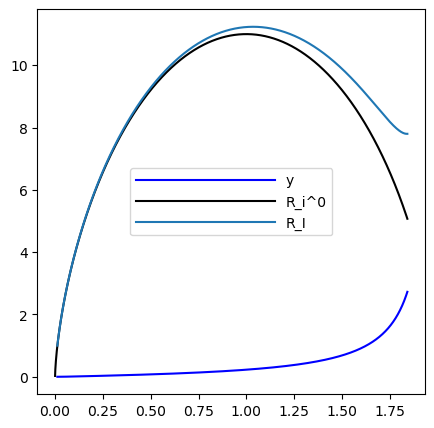

In [ ]:
G = 6.67*10**(-11) #Gravitational constant

R_in = 1 #initial radius
R_dot_in = 1 #initial speed of the radius
eps_in = 0.1 #energy overdensity
H_I = R_dot_in/R_in
rho_c_in = 3*(H_I)**2/(8*np.pi*G) #critical density
rho_in = rho_c_in*(1 + eps_in) #background density

t_ta = np.pi/2/(H_I*(eps_in)**(3/2))*(1 + eps_in)

#On met R_i^(1)(t = 0) = 0, tout comme sa dérivée
x_in = 1 
x_dot_in = 0.1
x_y_in = 0
x_y_dot_in = 0

def dyn_FRW_perturbe_p(t,y):
    R_i = y[0] #R_i^0 pour l'équation homogène
    dot_R_i = y[1]
    rho_tilde = y[2]
    x = y[3] #x qui suit le growing mode (utile pour k)
    x_dot = y[4]
    x_y = y[5] #y qui est la variable recherché et utilise le background R_i
    x_y_dot = y[6]
    H_I = dot_R_i/R_i
    rho_c = 3*H_I**2/(8*np.pi*G)

    #print(rho_tilde/rho_c + 2*E_in/dot_R_i**2)
    f = [dot_R_i,-4*np.pi*G*rho_tilde/3*R_i, -3*dot_R_i/R_i*rho_tilde, x_dot, (4*np.pi*G*rho_tilde*x - 2*H_I*x_dot), x_y_dot, (4*np.pi*G*rho_tilde*x_y - 2*H_I*x_y_dot + 2*0.01*(x_dot/x)**2) - 0.01*G*x**2/R_i**3]
    return f

#Résolution de la partie 'forward'
sol_p = solve_ivp(dyn_FRW_perturbe_p, [0,200], [R_in,R_dot_in,rho_in, x_in, x_dot_in, x_y_in, x_y_dot_in], t_eval = np.linspace(0,100,10000), rtol = 1e-9) #On perturbe rho avec epsilon

#Résolution de la partie 'backward'
sol_rev_p = solve_ivp(dyn_FRW_perturbe_p, [0,-70], [R_in,R_dot_in,rho_in, x_in, x_dot_in, x_y_in, x_y_dot_in], t_eval = np.linspace(0,-70,10000)) #On perturbe rho avec epsilon

m = np.min(sol_rev_p.t)
sol_p_t = np.flip(sol_rev_p.t)
Time = [(sol_p_t[i] - m)/t_ta for i in range(len(sol_p_t))] + [(sol_p.t[i] - m)/t_ta for i in range(1,len(sol_p.t))]
sol_rev_p = np.flip(sol_rev_p.y[0])
sol2 = [sol_rev_p[i] for i in range(len(sol_rev_p))] + [sol_p.y[0][i] for i in range(1,len(sol_p.y[0]))]
Time_R_1 = [(sol_p.t[i] - m)/t_ta for i in range(len(sol_p.t))]

R_I = sol_p.y[0] + sol_p.y[5]

plt.rcParams["figure.figsize"] = (5, 5)

line1,=plt.plot(Time_R_1, sol_p.y[5], color = 'blue')

line2,=plt.plot(Time, sol2, color = 'black')

line3, =plt.plot(Time_R_1, R_I)
plt.legend([line1, line2, line3], ['y', 'R_i^0', 'R_I'], handlelength = 10, fontsize = 10)
#plt.plot(sol_p.y[0]) #Univers en collapse sphérique

#y_max = np.max(sol_p.y[3])
#t_p = list(sol_p.y[3]).index(y_max)

#plt.plot([t_p for i in range(20)], [y_max*i/10 for i in range(20)], "--")

#plt.ylim(0,y_max)

Initial density

In [35]:
rho_in

1.1975747648360104e-05

Pour le halo 201

In [36]:
len(R_I)

10000

In [37]:
len(Time)

3180802

Data for halo 210.

In [78]:
#Inertial radius in comoving coordinate.
R_I = [4.024427678463254e+18, 4.928895211730655e+18,5.896048273563345e+18,6.661569739949222e+18,7.577104346050032e+18,8.27360248105929e+18,9.024603605321704e+18,9.674572821604542e+18,1.031524214274913e+19,1.103194492774645e+19,1.1512285877480227e+19,1.2564105623919661e+19,1.3620589452934965e+19,1.507862992006433e+19,1.6374971061425986e+19,1.8072307953159444e+19,2.016234862992345e+19,2.183022419317796e+19,2.343881445425878e+19,2.587306517208827e+19,2.851769082519256e+19,3.2047364000539337e+19,3.4522853514045075e+19,3.639955632611432e+19,3.780727224556719e+19,3.893209031778021e+19,3.982559989794311e+19,4.0565624417034306e+19]

#Scale factor of the whole universe
Scale_a = [1, 0.9537219490392906, 0.9095855560793044, 0.8757516765159388, 0.8352235958012078, 0.8041557601699713,
 0.7705836268786364, 0.7419202059930923, 0.7143229791820179, 0.684501211487295, 0.6653149581332802, 0.6255695465925124,
 0.5881984958251407, 0.5401111082343341, 0.5006773599460541, 0.45325613023749545, 0.40071934468037423, 0.3644885279628326, 0.3331081367707903,
 0.29034101878914165, 0.24949283896377988, 0.1996826997385783, 0.16677970249494836, 0.1426379409683697, .12491541593783131, 0.11096103078290759,
 0.09997660693201205, 0.0909372776111762]

#Physical inertial radius
R_I_phys = [R_I[i]*Scale_a[i] for i in range(len(Scale_a))]

eps_in = 0.8367673010853648 #eps_in lors du premier snapshot

#Hubble constant
Hubble_Param = [2.1993506493506494e-18, 2.3083497427072358e-18, 2.430519586220558e-18, 2.5706873564249483e-18, 2.7280716999951122e-18, 2.901146704386933e-18, 3.2688377960262462e-18, 3.904874952148154e-18, 5.15404869236822e-18, 6.615742801551587e-18, 9.977760003732331e-18, 1.3820597860082588e-17, 1.803976094725128e-17, 2.276439759532034e-17,2.7747525554145863e-17, 3.312153225828942e-17, 3.8711569491344644e-17, 4.4612395641801344e-17]

Data for halo 505.

In [64]:
R_I = [4.2119473474893256e+18,5.128045630799172e+18,6.173115351082109e+18,7.049709898501032e+18,8.161956113549763e+18,9.051674818611688e+18,1.0047413657436768e+19,1.0928214939125107e+19,1.1805309758825658e+19,1.2785452073203397e+19,1.3433324948743252e+19,1.4822263118162491e+19,1.6196613797205416e+19,1.8108260728411697e+19,1.9835285733529723e+19,2.2102336083177976e+19,2.4867141346527515e+19,2.695861422291149e+19,2.890506143219049e+19,3.1764673499045335e+19,3.4732096996265484e+19,3.865484741100052e+19,4.142432691442832e+19,4.354102618354315e+19,4.513808447111565e+19,4.641992446488562e+19,4.7443100014436745e+19,4.829397202525125e+19]

#Scale factor of the whole universe
Scale_a = [1, 0.9537219490392906, 0.9095855560793044, 0.8757516765159388, 0.8352235958012078, 0.8041557601699713,
 0.7705836268786364, 0.7419202059930923, 0.7143229791820179, 0.684501211487295, 0.6653149581332802, 0.6255695465925124,
 0.5881984958251407, 0.5401111082343341, 0.5006773599460541, 0.45325613023749545, 0.40071934468037423, 0.3644885279628326, 0.3331081367707903,
 0.29034101878914165, 0.24949283896377988, 0.1996826997385783, 0.16677970249494836, 0.1426379409683697, .12491541593783131, 0.11096103078290759,
 0.09997660693201205, 0.0909372776111762]

#Physical inertial radius
R_I_phys = [R_I[i]*Scale_a[i] for i in range(len(Scale_a))]

eps_in = 0.8097400474040394 #eps_in lors du premier snapshot

#Hubble constant
Hubble_Param = [2.1993506493506494e-18, 2.3083497427072358e-18, 2.430519586220558e-18, 2.5706873564249483e-18, 2.7280716999951122e-18, 2.901146704386933e-18, 3.2688377960262462e-18, 3.904874952148154e-18, 5.15404869236822e-18, 6.615742801551587e-18, 9.977760003732331e-18, 1.3820597860082588e-17, 1.803976094725128e-17, 2.276439759532034e-17,2.7747525554145863e-17, 3.312153225828942e-17, 3.8711569491344644e-17, 4.4612395641801344e-17]

This cell plots $R_I^{(0)}$ in the realistic case, i.e. with the same cosmological parameters and initial conditions as IllustrisTNG, for a certain halo. Recall that at the start of the expansion, we have $\dot{R}_I = H R_I (1 - \epsilon/3)$, which in theory directly provides the second initial condition.

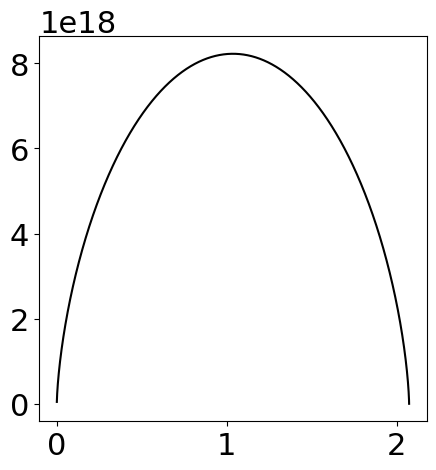

In [79]:
G = 6.67e-11
G = G*(10e-3)**2
Lambda = 1.088e-52 #Cosmological constant
Lambda = Lambda*10**(6) #En km
c = 3e5 #En km/s
a_in = R_I_phys[-1] #R_I au temps initial en Km
a_dot_in = Hubble_Param[-1]*a_in*(1 - eps_in/3) #en Km/s
H_I = a_dot_in/a_in
rho_c_in = 3*H_I**2/(8*np.pi*G)
rho_in = rho_c_in*(1 + eps_in)

x_in = a_in
x_dot_in = 0.1*a_dot_in
x_y_in = 0
x_y_dot_in = 0

coef = 3e3

def dyn_FRW_perturbe_p(t,y):
    R_i = y[0] #R_i^0 pour l'équation homogène
    dot_R_i = y[1]
    rho_tilde = y[2]
    x = y[3] #x qui suit le growing mode (utile pour k)
    x_dot = y[4]
    x_y = y[5] #y qui est la variable recherché et utilise le background R_i
    x_y_dot = y[6]
    H_I = dot_R_i/R_i
    rho_c = 3*H_I**2/(8*np.pi*G)

    #print(rho_tilde/rho_c + 2*E_in/dot_R_i**2)
    f = [dot_R_i,-4*np.pi*G*rho_tilde/3*R_i + Lambda/3*c**2*R_i, -3*dot_R_i/R_i*rho_tilde , x_dot, (4*np.pi*G*rho_tilde*x - 2*H_I*x_dot) + Lambda/3*c**2*x, x_y_dot, (4*np.pi*G*rho_tilde*x_y - 2*H_I*x_y_dot + 2*coef*(x_dot/x)**2) - coef*G*x**2/R_i**3]
    return f

t_ta = np.pi*(1 + eps_in)/(2*H_I*eps_in**(3/2)) #Time of turn-around
R_ta = (1 + eps_in)/eps_in*a_in #Radius of turn-around

sol_p_2 = solve_ivp(dyn_FRW_perturbe_p, [0,3e17], [a_in,a_dot_in,rho_in, x_in, x_dot_in, x_y_in, x_y_dot_in], t_eval = np.linspace(0,3e17,10000), rtol = 1e-11) #forward evolution
sol_rev_p_2 = solve_ivp(dyn_FRW_Lambda, [0,-3e17], [a_in,a_dot_in,rho_in], t_eval = np.linspace(0,-3e17,10000)) # Backward evolution

m = np.min(sol_rev_p_2.t)
sol_p_t = np.flip(sol_rev_p_2.t)

# Normalization of time relative to the turn-around instant.
Time = [(sol_p_t[i] - m)/t_ta for i in range(len(sol_p_t))] + [(sol_p_2.t[i] - m)/t_ta for i in range(1,len(sol_p_2.t))]

#Scale factor for an overdensity eps_in at initial time.
sol_rev_p = np.flip(sol_rev_p_2.y[0])
sol2 = [sol_rev_p[i] for i in range(len(sol_rev_p))] + [sol_p_2.y[0][i] for i in range(1,len(sol_p_2.y[0]))]
Time_R_1 = [(sol_p_2.t[i] - m)/t_ta for i in range(len(sol_p_2.t))]

R_I = sol_p_2.y[0] + sol_p_2.y[5]

plt.rcParams["figure.figsize"] = (5, 5)

#line1,=plt.plot(Time_R_1, sol_p_2.y[5], color = 'blue')

#plt.plot(Time_R_1, -sol_p_2.y[5]/R_ta)

line2,=plt.plot(Time, sol2, color = 'black')

#line3, plt.plot(Time_R_1, R_I)
#plt.legend([line1, line2, line3], ['R_i^1', 'R_i^0', 'R_I'], handlelength = 10, fontsize = 10)
#plt.plot(sol_p.y[0]) #Univers en collapse sphérique

#y_max = np.max(sol_p.y[3])
#t_p = list(sol_p.y[3]).index(y_max)

#plt.plot([t_p for i in range(20)], [y_max*i/10 for i in range(20)], "--")

#plt.ylim(0,y_max)

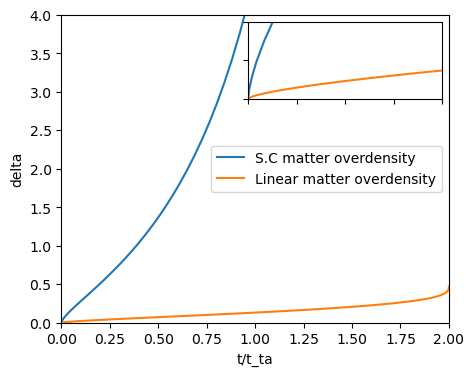

In [4]:
fig, ax = plt.subplots(figsize=(5,4))
def delta_r(eta):
    return 9/2*(eta - np.sin(eta))**2/(1 - np.cos(eta))**3 - 1

def delta_l(eta):
    return 3/5*(3/4*(eta/np.pi - np.sin(eta/np.pi))**(2/3))

eta = [2*np.pi*i/100 for i in range(1,100)]
T = [eta_/np.pi - np.sin(eta_)/np.pi for eta_ in eta]

d_r = [delta_r(eta[i]) for i in range(len(eta))]
d_l = [delta_l(eta[i]) for i in range(len(eta))]

ax.plot(T, d_r, label = 'S.C matter overdensity')
ax.plot(T, d_l, label = 'Linear matter overdensity')
ax.legend()
plt.ylim(0,4)
plt.xlim(0,2)
plt.xlabel('t/t_ta')
plt.ylabel('delta')
axins = zoomed_inset_axes(ax, 50, loc=1)
axins.plot(T, d_r)
axins.plot(T,d_l)
axins.set_xlim(0, 0.02)
axins.set_ylim(0, 0.02)
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.draw()
plt.show()

Text(0.5, 1.0, 'Speed of collapse')

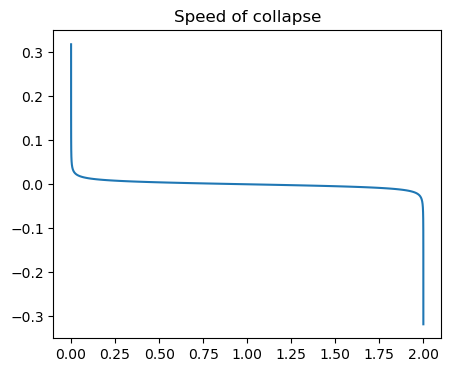

In [5]:
fig, ax = plt.subplots(figsize=(5,4))
def vit(A,eta):
    return A*np.sin(eta)/(1 - np.cos(eta))

eta = [2*np.pi*i/100 for i in range(1,100)]
T = [eta_/np.pi - np.sin(eta_)/np.pi for eta_ in eta]

A = [0.01]
v_r = [vit(a, eta) for a in A]
for i in range(1):
    plt.plot(T,v_r[i])
plt.title('Speed of collapse')

This curve is plotted using the data from IllustrisTNG simulation.

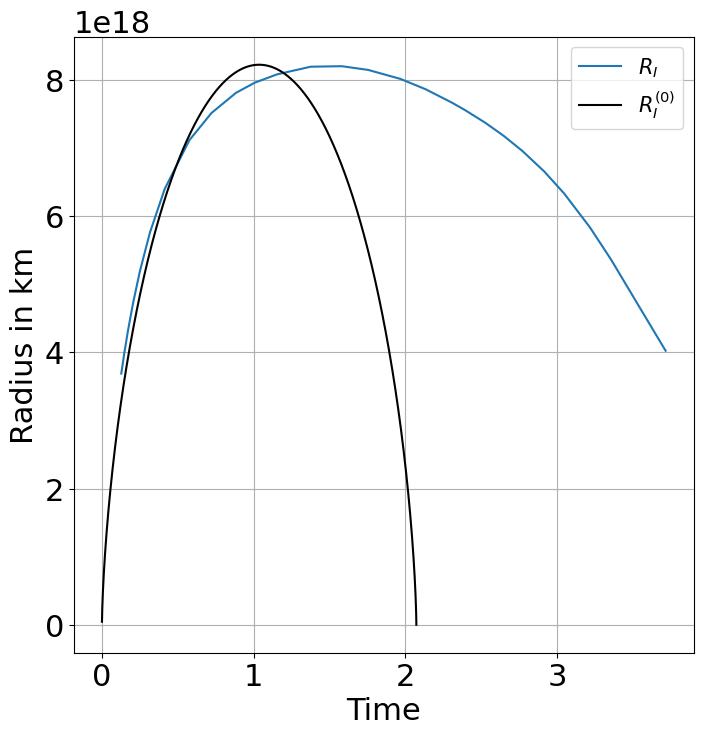

In [80]:
#Time in simulation IllustrisTNG
plt.figure(figsize=(8,8))
Time_r = np.array([13.797, 13.121, 12.461, 11.945, 11.317, 10.828, 10.293, 9.832, 9.384, 8.896, 8.581, 7.926, 7.309, 6.517, 5.873, 5.111, 4.288, 3.740, 3.280, 2.681, 2.142, 1.537, 1.174, 0.929, 0.761, 0.637, 0.545, 0.473])*31557600*10**9
R_I_phys_norm = [R_I_phys[i] for i in range(len(Time_r))]
plt.plot(Time_r/t_ta, R_I_phys_norm, label = '$R_I$')
plt.plot(Time, sol2, color = 'black', label = '$R_I^{(0)}$')
plt.xlabel('Time')
plt.ylabel('Radius in km')
plt.legend(prop={'size': 15})
plt.grid('on')

For Halo N°505:

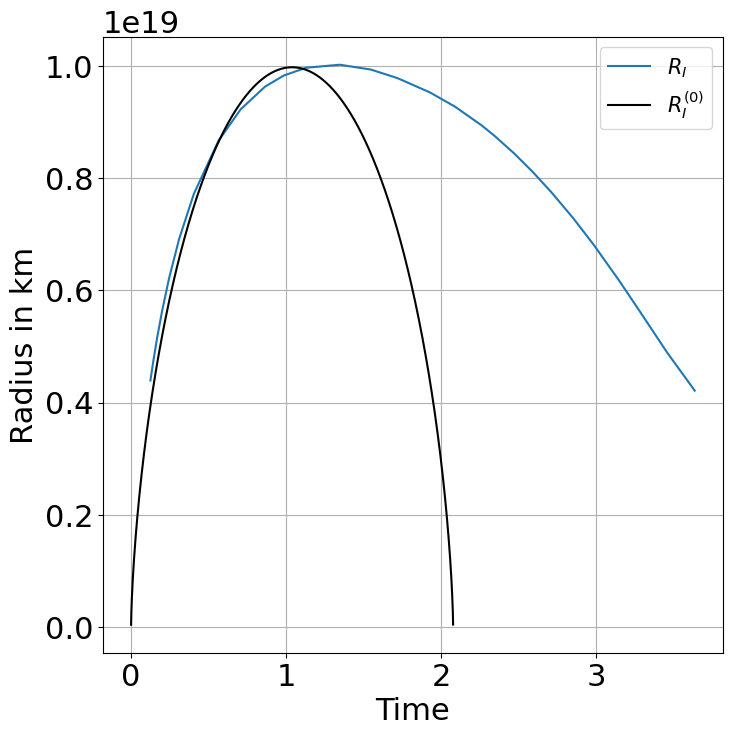

In [77]:
#Time in simulation IllustrisTNG
plt.figure(figsize=(8,8))
Time_r = np.array([13.797, 13.121, 12.461, 11.945, 11.317, 10.828, 10.293, 9.832, 9.384, 8.896, 8.581, 7.926, 7.309, 6.517, 5.873, 5.111, 4.288, 3.740, 3.280, 2.681, 2.142, 1.537, 1.174, 0.929, 0.761, 0.637, 0.545, 0.473])*31557600*10**9
R_I_phys_norm = [R_I_phys[i] for i in range(len(Time_r))]
plt.plot(Time_r/t_ta, R_I_phys_norm, label = '$R_I$')
plt.plot(Time, sol2, color = 'black', label = '$R_I^{(0)}$')
plt.xlabel('Time')
plt.ylabel('Radius in km')
plt.legend(prop={'size': 15})
plt.grid('on')